# Hello Score!
Author: Charlie, Geometric AI Lab

Welcome to *beta* run of Score Based Modeling.
This notebook will help you implement basic SDE-based Diffusion Models.
You will have hands on experience deriving OU-process along with VPSDE and VESDE
and see how they affect the diffusion process. You will first build simple model 
to predict the score as well as the sampling process for a simple 2D toy dataset. You will then 
build slightly more complicated model on images. Finally, you will have to implement a different kind of 
diffusion model called Schrodinger Bridge and see their connection. The assignment breakdown into three parts:

1. Basic of SDE <br>
  1.1 VPSDE vs. VESDE
2. Learning Score and Sampling <br>
  2.1 DDPM 
3. Moving to MNIST <br>
  3.1 ResNet, UNet, EMA (TBD)
4. Schrodinger Bridge (TBD)
5. Riemannian Diffusion (TBD)
6. Jump Diffusion (TBD)

For question please contact Charlie hieuristics@kaist.ac.kr

Codebase inspired by <https://vdeborto.github.io/project/generative_modeling/> 

### 1.1 Dataset
The following code contain the dataset that you will use throughout the first part. 

The goal of the first part is to learn the diffusion process that reverse the prior distrbution (orange) to the target distribution (blue). Once, we learned such a process, we can then sample from the prior distribution and diffusion those samples to the target distribution. 


/var/folders/sk/q6fcfx4s28jg7rsckf95wc100000gn/T/ipykernel_16789/1931555980.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample)


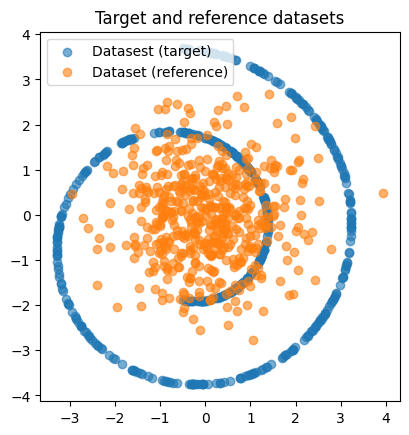

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets
import matplotlib.pyplot as plt

def load_twodim(num_samples, dataset, dimension=2):
    
    if dataset == 'gaussian_centered':
        sample = torch.randn(num_samples, dimension)
        sample = sample
    
    if dataset == 'gaussian_shift':
        sample = torch.randn(num_samples, 2)
        sample = sample + 1.5

    if dataset == 'circle':
        X, y = datasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=.5)
        sample = X * 4
        
    if dataset == 'scurve':
        X, y = datasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None)
        init_sample = X[:, [0, 2]]
        scaling_factor = 2
        sample = (init_sample - init_sample.mean()) / \
            init_sample.std() * scaling_factor
        
    if dataset == 'swiss_roll':
        X, y = datasets.make_swiss_roll(
            n_samples=num_samples, noise=0.0, random_state=None, hole=True)
        init_sample = X[:, [0, 2]]
        scaling_factor = 2
        sample = (init_sample - init_sample.mean()) / \
            init_sample.std() * scaling_factor
        
    return torch.tensor(sample)


class TwoDimDataClass(Dataset):

    def __init__(self,
                 dataset_type: str,
                 N: int,
                 batch_size: int,
                 dimension = 2):

        self.X = load_twodim(N, dataset_type, dimension=dimension)
        self.name = dataset_type
        self.batch_size = batch_size
        self.dimension = 2

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]
    
    def get_dataloader(self, shuffle=True):
        return DataLoader(self, 
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
        )

    
target_ds = TwoDimDataClass(dataset_type='swiss_roll', 
                            N=1000000, 
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

Ntest = 500
sample_f = target_ds[0:Ntest]
sample_b = prior_ds[0:Ntest]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and reference datasets"
ax.set_title(strtitle)
ax.legend(['Datasest (target)', 'Dataset (reference)'])

### 1.2 SDE Class
The following abstract base class define the abstract method that all `SDE` shares. This include a reverse process that you will have to implement. Assuming that our `SDE` are *Ornstein-Uhlenbeck* processes:

$$
\mathrm{d}\mathbf{X}_t = \mu \mathbf{X}_t \mathrm{d}t + \sigma \mathrm{d}\mathbf{B}_t, \quad\mathbf{X}_0 \sim \pi_0.
$$

Here, $\mu$ is the drift term and $\sigma$ is the diffusion term. As we know, the backward process is has the following form:

$$
\mathrm{d}\mathbf{Y}_t = \left(-\mu\mathbf{Y}_t + \sigma^2\nabla \log_{p_{T-t}}(\mathbf{Y}_t)\right)\mathrm{d}t + \sigma \mathrm{d}\mathbf{B}_t \quad\mathbf{Y}_0 \sim \pi_T.
$$

**IMPORTANT**! The score term $\nabla p_t$ in the reverse process is the **same** score from the forward process. Therefore, in the reverse process, this score should be **reversed** as $\nabla p_{T-t}$. `self.model(t,xt)` returns the $\nabla p_{t}(\mathbf{X}_t)$. 

**TODO**: Implement the reverse diffusion process. 

In [2]:
import abc
from typing import Any

class SDE(abc.ABC):
    def __init__(self, N, T):
        super().__init__()
        self.N = N         # number of time step
        self.T = T         # end time
    
    @abc.abstractmethod
    def sde_coeff(self, t, x):
        pass
    
    @abc.abstractmethod
    def marginal_prob(self, t, x):
        pass
    
    @abc.abstractmethod
    def prior_sampling(self, t, x):
        pass
    
    def reverse(self, model):
        N = self.N
        T = self.T
        sde_coeff = self.sde_coeff
        
        def get_reverse_drift_fn(model_fn):
            def reverse_drift_fn(t, x):
                # TO FILL
                drift, diffusion = sde_coeff(self.T-t, x)
                score = model_fn(self.T-t, x)
                reverse_drift = - drift + score * (diffusion ** 2)
                return reverse_drift
            return reverse_drift_fn
        
        class RSDE(self.__class__):
            def __init__(self, model):
                self.N = N
                self.T = T
                self.model = model
                self.reverse_drift_fn = get_reverse_drift_fn(model)
            
            def sde_coeff(self, t, x):
                _, diffusion = sde_coeff(self.T-t, x)
                drift = self.reverse_drift_fn(t, x)
                return drift, diffusion
                
        return RSDE(model)
    
    def discretize(self):
        pass

In [3]:
class OrnsteinUhlenbeck(SDE):
    def __init__(self, N=100, T=1):
        super().__init__(N, T)

    def sde_coeff(self, t, x):
        drift = -0.5 * x
        diffusion = torch.ones(x.shape)
        return drift, diffusion

    def marginal_prob(self, t, x):
        mean = torch.exp(-0.5 * t).unsqueeze(1) * x
        std = torch.sqrt(1 - torch.exp(-t)).unsqueeze(1) * torch.ones_like(x)
        return mean, std

    def prior_sampling(self, shape):
        return torch.randn(shape)

class VPSDE(SDE):
    def __init__(self, N=100, T=1):
        super().__init__(N, T)

    def sde_coeff(self, t, x):
        drift = -0.5 * x
        diffusion = torch.ones(x.shape)
        return drift, diffusion

    def marginal_prob(self, t, x):
        mean = torch.exp(-0.5 * t).unsqueeze(1) * x
        std = torch.sqrt(1 - torch.exp(-t)).unsqueeze(1) * torch.ones_like(x)
        return mean, std

    def prior_sampling(self, shape):
        return torch.randn(shape)
    
class VESDE(SDE):
    

sde = OrnsteinUhlenbeck(T=1)

100%|█| 100/100 [00:00<00:00, 838.


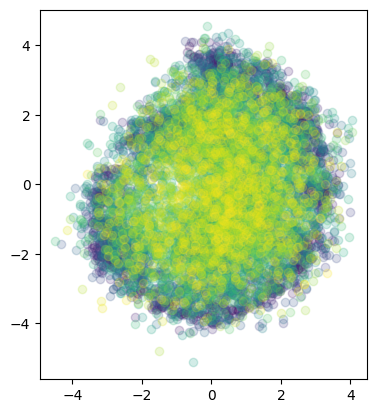

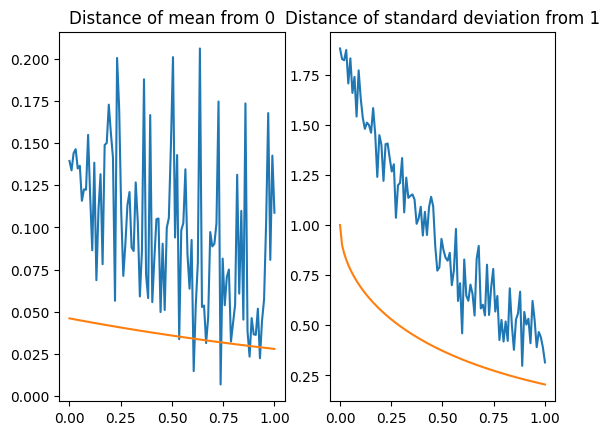

In [4]:
from tqdm import tqdm

cmap = plt.get_cmap('viridis')

n_arr = 100
plot_Ntest = 100

t_arr = np.linspace(0, sde.T, n_arr)
mean_arr = np.zeros((n_arr, 1))
std_arr = np.zeros((n_arr, 1))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for k, tt in enumerate(tqdm(t_arr)):
    x0 = target_ds[range(plot_Ntest)].float()
    t = torch.zeros((x0.shape[0],)) + tt
    mean, std = sde.marginal_prob(t, x0)
    # print(std.max())
    z = torch.randn(mean.shape)
    xt = mean + std * z

    mean_arr[k] = (xt.mean(axis=0)**2).sum()
    std_arr[k]  = ((xt.std(axis=0) - 1)**2).sum()

    ax.scatter(xt[:, 0], xt[:, 1], alpha=0.2, color=cmap(tt/t_arr[-1]))


# E[xT] = X0e^(-0.5*T)
# V[xT] = 1 - e^(-T)
x0 = target_ds[range(plot_Ntest)].float()
true_mean = x0.mean() * np.exp(-0.5*t_arr)
true_std = np.abs(np.sqrt(1 - np.exp(-t_arr)) - 1)

ax.grid(False)
ax.set_aspect('equal', adjustable='box')

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.plot(t_arr, np.abs(mean_arr))
plt.plot(t_arr, np.abs(true_mean))
plt.title("Distance of mean from 0")
ax.grid(False)
ax = fig.add_subplot(1, 2, 2)
plt.plot(t_arr, std_arr)
plt.plot(t_arr, true_std)
plt.title("Distance of standard deviation from 1")
ax.grid(False)
plt.savefig("./mean_std.jpg")

### Let's Learn Some Score!

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class PositionalEncoding(nn.Module):
    def __init__(self, t_channel):
        super().__init__()
        half_dim = t_channel // 2
        freq = np.log(10000) / (half_dim - 1)
        self.modulation = torch.exp(torch.arange(half_dim) * -freq)
        
    def forward(self, t):
        emb = t[:, None] * self.modulation[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        return emb

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_shapes):
        super().__init__()
        layers = [nn.Linear(in_dim, hid_shapes[0]), nn.ReLU()]
        for i, hid_dim in enumerate(hid_shapes[1:]):
            layers += [nn.Linear(hid_shapes[i-1], hid_shapes[i]), nn.ReLU()]
        layers += [nn.Linear(hid_shapes[-1], out_dim)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class Naive(nn.Module):
    
    def __init__(self, in_dim, enc_shapes, dec_shapes, z_dim):
        super().__init__()
        self.pe = PositionalEncoding(z_dim)
        self.x_enc = MLP(in_dim, z_dim, enc_shapes)
        self.t_enc = MLP(z_dim, z_dim, enc_shapes)
        self.dec = MLP(2*z_dim, in_dim, dec_shapes) 
    
    def forward(self, t, x):
        temb = self.pe(t)
        temb = self.t_enc(temb)
        xemb = self.x_enc(x)
        h = torch.cat([xemb, temb], -1)

        return -self.dec(h)
    

model = Naive(in_dim=2, enc_shapes=[32,32], dec_shapes=[64,64], z_dim=32)
model_ema = Naive(in_dim=2, enc_shapes=[32,32], dec_shapes=[64,64], z_dim=32)

In [6]:
from torch.optim import Adam
from torch_ema import ExponentialMovingAverage

class DSMLoss():

    def __init__(self, alpha: float, diff_weight: bool):
        self.alpha = alpha
        self.diff_weight = diff_weight
        self.mseloss = torch.nn.MSELoss()

    def __call__(self, pred, target, diff_sq):
        reg = self.alpha * pred**2
        loss = self.mseloss(pred, target) + reg  
        
        if self.diff_weight:
            loss = loss / diff_sq
        
        loss = loss.mean()
        return loss
    
class ISMLoss():

    def __init__(self):
        # TODO 
        return
        
    def __call__(self):
        # TODO
        return 

loss_fn = DSMLoss(alpha=0.3, diff_weight=True)
optimizer = Adam(model.parameters(), lr=1e-4)
ema =  ExponentialMovingAverage(model.parameters(), decay=0.99)

In [7]:
def get_step_fn(loss_fn, optimizer, ema, sde, model):
    def step_fn(batch):
        # uniformly sample time step 
        t = sde.T*torch.rand(batch.shape[0])
        
        # forward diffusion
        mean, std = sde.marginal_prob(t, batch)
        _, diffusion = sde.sde_coeff(t, batch)
        diff_sq = diffusion ** 2
        z = torch.randn(mean.shape)
        xt = mean + std * z
        
        # make training batch
        target = - (z / std).float()
        pred = model(t, xt.float())
        
        # get loss
        loss = loss_fn(pred, target, diff_sq)
        
        # optimize model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ema.update()

        return loss.item()
    
    return step_fn


step_fn = get_step_fn(loss_fn, optimizer, ema, sde, model)

Loss: 6.803: █| 15000/15000 [00:15


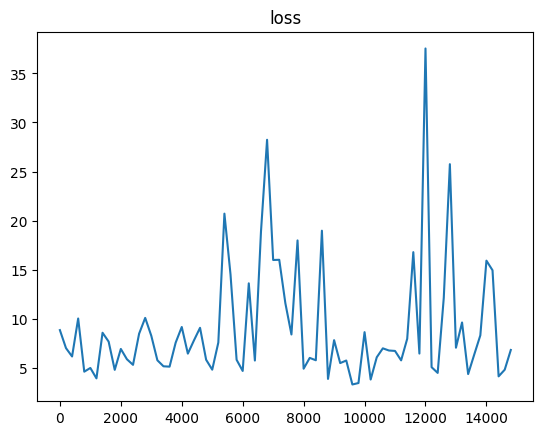

In [8]:
from tqdm import tqdm
from itertools import repeat

def repeater(data_loader):
    for loader in repeat(data_loader):
        for data in loader:
            yield data
            

def train_diffusion(dataloader, N_steps):
    pbar = tqdm(range(N_steps), bar_format="{desc}{bar}{r_bar}", mininterval=1)
    loader = iter(repeater(dataloader))

    log_freq = 200
    loss_history = np.zeros(N_steps//log_freq)
    for i, step in enumerate(pbar):
        batch = next(loader)
        loss = step_fn(batch)
        
        if step % log_freq == 0:
            loss_history[i//log_freq] = loss
            pbar.set_description("Loss: {:.3f}".format(loss))
    

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("loss")
    plt.plot(np.array(range(loss_history.shape[0]))*log_freq, loss_history)
    

N_steps = 15000
train_diffusion(target_ds.get_dataloader(), N_steps)

# Sampling 

In [9]:
import abc

class Predictor(abc.ABC):

    def __init__(self, sde):
        super().__init__()
        self.sde = sde

    @abc.abstractmethod
    def update_fn(self, t, x):
        pass

class EulerMaruyamaPredictor(Predictor):
    def __init__(self, sde):
        super().__init__(sde)

    def update_fn(self, t, x):
        dt = 1. / self.sde.N
        # dt = 1e-5
        z = torch.randn(x.shape)
        drift, diffusion = self.sde.sde_coeff(t, x)
        x_mean = x + dt * drift
        x = x_mean + diffusion * (z * (dt ** 0.5))
        return x, x_mean

class Sampler():

    def __init__(self, eps):
        self.eps = eps

    def get_sampling_fn(self, sde, dataset):
    
        update_fn = EulerMaruyamaPredictor(sde).update_fn

        def sampling_fn(N_samples):
            # Initial sample
            x = dataset[range(N_samples)]
            timesteps = torch.linspace(0, sde.T-self.eps, sde.N)

            x_hist = torch.zeros((sde.N, *x.shape))
            with torch.no_grad():
                for i, t in enumerate(tqdm(timesteps, desc='sampling')):
                    t_vec = torch.ones(x.shape[0]) * t
                    x, _ = update_fn(t_vec, x)
                    x_hist[i] = x

            out = x
            ntot = sde.N
            return out, ntot, timesteps, x_hist

        return sampling_fn

ema.copy_to(model_ema.parameters())
sde_backward = sde.reverse(model)
sampler = Sampler(eps=1e-3)
sampler_fn = sampler.get_sampling_fn(sde_backward, prior_ds)

plot_Ntest = 200
out, ntot, timesteps, x_hist = sampler_fn(N_samples=plot_Ntest)

sampling: 100%|█| 100/100 [00:00<0


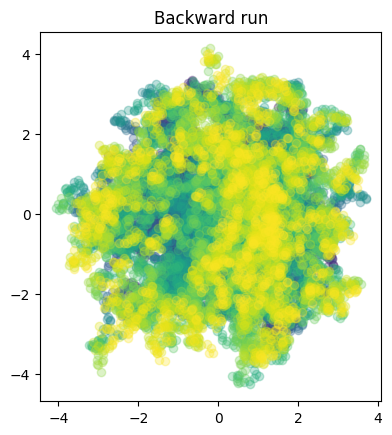

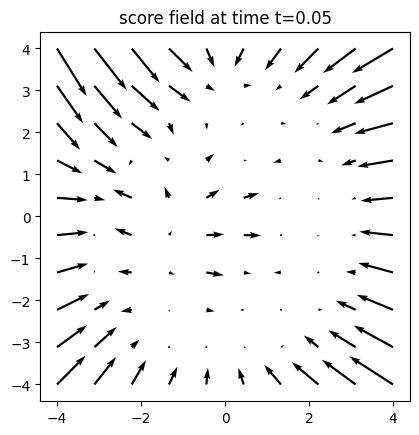

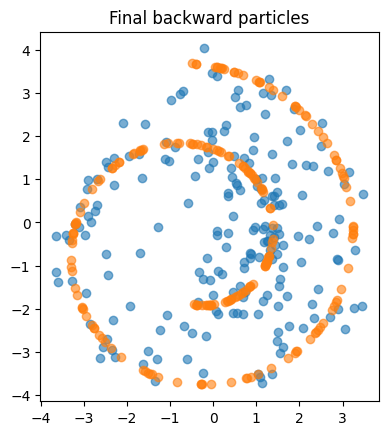

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t_arr = np.linspace(0, sde.T, sde.N)

for k, tt in enumerate(t_arr):
    outk = x_hist[k]
    ax.scatter(outk[:, 0], outk[:, 1], alpha=0.3, color=cmap(tt/t_arr[-1]))
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Backward run"
ax.set_title(strtitle)
plt.savefig("./backward_run.jpg")

xmin, xmax = -4, 4
ymin, ymax = -4, 4
xx, yy = np.mgrid[xmin:xmax:10j, ymin:ymax:10j]
fig = plt.figure()
t0 = 0.05
x = np.concatenate(
    (xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=-1)
t = np.zeros((x.shape[0],)) + t0

x_tensor = torch.tensor(x).float()
t_tensor = torch.tensor(t, ).float()
# with torch.no_grad():
with torch.no_grad(), ema.average_parameters():
    out = model(t_tensor, x_tensor)

u = out[:, 0].reshape(xx.shape)
v = out[:, 1].reshape(yy.shape)
ax = fig.add_subplot(1, 1, 1)
ax.quiver(xx, yy, u, v)
ax.set_aspect('equal', adjustable='box')
strtitle = f"score field at time t={t0}"
ax.set_title(strtitle)
plt.savefig("./score_vector_field.jpg")

out_true = target_ds[range(0, plot_Ntest)]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_hist[-1, :, 0], x_hist[-1, :, 1], alpha=0.6)
ax.scatter(out_true[:, 0], out_true[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Final backward particles"
ax.set_title(strtitle)
plt.savefig("./final_backward.jpg")